In [1]:
import os.path as osp

import torch
import torch.nn.functional as F

import torch_geometric as tg
from torch_geometric.loader import DataLoader
from torch_geometric.nn import TopKPooling, global_max_pool, global_mean_pool
import sys
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../")
import utils
import warnings

warnings.filterwarnings("ignore")

In [2]:
train_dataset = utils.GraphDataset("../data/", "GunPoint", True, n_quantiles=41)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

test_dataset = utils.GraphDataset("../data/", "GunPoint", False, n_quantiles=41)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
for elem in train_dataset:
    break
elem

(50, 150)
(150, 150)


Data(edge_index=[2, 124], weight=[124], x=[41, 4], y=1, edge_attr=[124, 1])

In [3]:
class Net(torch.nn.Module):
    def __init__(self, in_features, hidden_channels=12, ratio=0.8):
        super().__init__()
        nn = tg.nn.MLP([in_features, hidden_channels])
        self.conv1 = tg.nn.GINEConv(nn, edge_dim=1)
        self.pool1 = TopKPooling(hidden_channels, ratio=ratio)
        nn = tg.nn.MLP([hidden_channels, hidden_channels])
        self.conv2 = tg.nn.GINEConv(nn, edge_dim=1)
        self.pool2 = TopKPooling(hidden_channels, ratio=ratio)
        nn = tg.nn.MLP([hidden_channels, hidden_channels])
        self.conv3 = tg.nn.GINEConv(nn, edge_dim=1)
        self.pool3 = TopKPooling(hidden_channels, ratio=ratio)

        self.lin1 = torch.nn.Linear(2 * hidden_channels, 16)
        self.lin2 = torch.nn.Linear(16, 8)
        self.lin3 = torch.nn.Linear(8, 2)

    def forward(self, data):
        x, edge_index, batch, edge_attr = (
            data.x,
            data.edge_index,
            data.batch,
            data.edge_attr,
        )

        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x, edge_index, edge_attr, batch, _, _ = self.pool1(
            x, edge_index, edge_attr, batch
        )
        x1 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x, edge_index, edge_attr, batch, _, _ = self.pool2(
            x, edge_index, edge_attr, batch
        )
        x2 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index, edge_attr))
        x, edge_index, edge_attr, batch, _, _ = self.pool3(
            x, edge_index, edge_attr, batch
        )
        x3 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)

        x = x1 + x2 + x3

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.log_softmax(self.lin3(x), dim=-1)

        return x

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(4, hidden_channels=20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, patience=5, mode="min", cooldown=2, factor=0.5, verbose=True
# )

In [5]:
def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        y_out = model(data)
        loss = F.nll_loss(y_out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()
    y_pred = []
    y_true = []
    loss = 0
    for data in loader:
        y_out = model(data)
        y_pred.append(y_out.argmax(dim=-1))
        y_true.append(data.y)
        loss += float(F.nll_loss(y_out, data.y) * data.num_graphs)
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    return (
        f1_score(y_true=y_true, y_pred=y_pred, average="macro"),
        accuracy_score(y_true=y_true, y_pred=y_pred),
        loss / len(loader.dataset),
    )

In [10]:
best_macro_f1 = -1
train_losses = []
val_losses = []
for epoch in range(550):
    train()
    train_macro_f1, train_acc, train_loss = test(train_loader)
    test_macro_f1, test_acc, test_loss = test(test_loader)
    # scheduler.step(train_loss)
    print(
        f"Epoch: {epoch:03d}, Train_Loss: {train_loss:02.4f},Test_Loss: {test_loss:02.4f},Train_f1: {train_macro_f1:01.4f},Test_f1: {test_macro_f1:01.4f},Train_acc: {train_acc:01.4f},Test_acc: {test_acc:01.4f}"
    )
    if test_macro_f1 > best_macro_f1:
        best_accuracy = test_macro_f1
        best_epoch = epoch
        torch.save(model.state_dict(), "../data/quantile-TopK_GIN2.pth")
    train_losses.append(train_loss)
    val_losses.append(test_loss)

Epoch: 000, Train_Loss: 0.6500,Test_Loss: 0.6700,Train_f1: 0.6264,Test_f1: 0.5042,Train_acc: 0.6600,Test_acc: 0.5733
Epoch: 001, Train_Loss: 0.6493,Test_Loss: 0.6684,Train_f1: 0.6264,Test_f1: 0.5454,Train_acc: 0.6600,Test_acc: 0.6000
Epoch: 002, Train_Loss: 0.6492,Test_Loss: 0.6689,Train_f1: 0.6528,Test_f1: 0.5638,Train_acc: 0.6800,Test_acc: 0.6067
Epoch: 003, Train_Loss: 0.6483,Test_Loss: 0.6680,Train_f1: 0.6847,Test_f1: 0.5678,Train_acc: 0.7000,Test_acc: 0.6067
Epoch: 004, Train_Loss: 0.6479,Test_Loss: 0.6678,Train_f1: 0.7029,Test_f1: 0.5638,Train_acc: 0.7200,Test_acc: 0.6067
Epoch: 005, Train_Loss: 0.6481,Test_Loss: 0.6677,Train_f1: 0.6782,Test_f1: 0.5638,Train_acc: 0.7000,Test_acc: 0.6067
Epoch: 006, Train_Loss: 0.6486,Test_Loss: 0.6687,Train_f1: 0.6264,Test_f1: 0.5454,Train_acc: 0.6600,Test_acc: 0.6000
Epoch: 007, Train_Loss: 0.6491,Test_Loss: 0.6695,Train_f1: 0.6435,Test_f1: 0.4935,Train_acc: 0.6800,Test_acc: 0.5667
Epoch: 008, Train_Loss: 0.6494,Test_Loss: 0.6703,Train_f1: 0.615

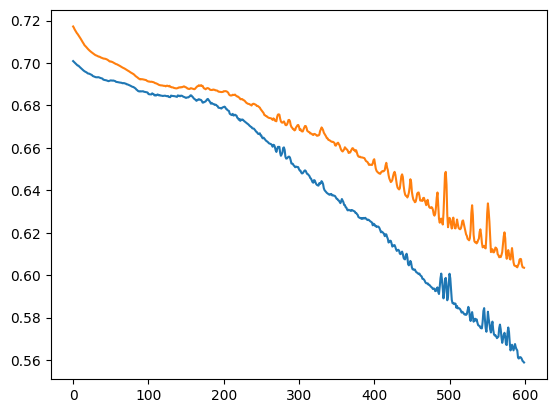

In [11]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()